# Applying K-Prototype Clustering to Classify Health Care Provider Data in the US

#### By Patcharaporn "Nam" Maneerat

This project aims to classify the nonlabel health care provider data and to identify fraudulent and nonfraudulent providers in the US. The healthcare provider data is obtained from https://www.kaggle.com/tamilsel/healthcare-providers-data, and you can find the description of individual columns via the link.

Note that since K-Means works best with the numerical data, and K-Mode nicely handle clustering with categorical data, K-Prototype developed by Huang (1998) seems to be a clusterng method that is better to use with a mixed dataset, which will be applied in this project. 

*For more information of K-Prototype Clustering:  Z. Huang. Extensions to the k-Means Algorithm for Clustering
Large Data Sets with Categorical Values (1998). Data Mining and Knowledge Discovery. 2(3): 283–304.*

## Dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_csv('Healthcare Providers.csv')
df.head()

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,...,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,8774979,1891106191,UPADHYAYULA,SATYASREE,NaN,M.D.,F,I,1402 S GRAND BLVD,FDT 14TH FLOOR,...,99223,"Initial hospital inpatient care, typically 70 ...",N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
1,3354385,1346202256,JONES,WENDY,P,M.D.,F,I,2950 VILLAGE DR,NaN,...,G0202,"Screening mammography, bilateral (2-view study...",N,175,175,175,123.73,548.8,118.83,135.31525714
2,3001884,1306820956,DUROCHER,RICHARD,W,DPM,M,I,20 WASHINGTON AVE,STE 212,...,99348,"Established patient home visit, typically 25 m...",N,32,13,32,90.65,155,64.4396875,60.5959375
3,7594822,1770523540,FULLARD,JASPER,NaN,MD,M,I,5746 N BROADWAY ST,NaN,...,81002,"Urinalysis, manual test",N,20,18,20,3.5,5,3.43,3.43
4,746159,1073627758,PERROTTI,ANTHONY,E,DO,M,I,875 MILITARY TRL,SUITE 200,...,96372,Injection beneath the skin or into muscle for ...,N,33,24,31,26.52,40,19.539393939,19.057575758


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   index                                                     100000 non-null  int64  
 1   National Provider Identifier                              100000 non-null  int64  
 2   Last Name/Organization Name of the Provider               100000 non-null  object 
 3   First Name of the Provider                                95745 non-null   object 
 4   Middle Initial of the Provider                            70669 non-null   object 
 5   Credentials of the Provider                               92791 non-null   object 
 6   Gender of the Provider                                    95746 non-null   object 
 7   Entity Type of the Provider                               100000 non-null  object 
 8   Stree

There are mixed data types, and some columns contain null. Next, we need to clean the data.

## Data Cleaning

In [8]:
# check which columns contain null values
df.isnull().sum()

index                                                           0
National Provider Identifier                                    0
Last Name/Organization Name of the Provider                     0
First Name of the Provider                                   4255
Middle Initial of the Provider                              29331
Credentials of the Provider                                  7209
Gender of the Provider                                       4254
Entity Type of the Provider                                     0
Street Address 1 of the Provider                                0
Street Address 2 of the Provider                            59363
City of the Provider                                            0
Zip Code of the Provider                                        0
State Code of the Provider                                      0
Country Code of the Provider                                    0
Provider Type                                                   0
Medicare P

Since all these columns with null values either provide similar information as other columns or do not seem to be useful for the clustering (i.e., firstname and middle initial) and there are only 5 of them, we will drop them.

In [9]:
cleaned_df = df.dropna(axis=1)
cleaned_df.shape

(100000, 22)

In this study, we only need the data of the providers in the US, so we will drop the data of those from other countries.

In [10]:
cleaned_df['Country Code of the Provider'].value_counts() # let's only do US

US    99994
DE        3
JP        2
TR        1
Name: Country Code of the Provider, dtype: int64

In [11]:
cleaned_df = cleaned_df[cleaned_df['Country Code of the Provider'] == 'US']
cleaned_df['Country Code of the Provider'].value_counts()

US    99994
Name: Country Code of the Provider, dtype: int64

We will also only include the states in the US and remove other territories outside the US, which are listed as follows:

- 'XX' = 'Unknown'
- 'AA' = 'Armed Forces Central/South America'
- 'AE' = 'Armed Forces Europe'
- 'AP' = 'Armed Forces Pacific'
- 'AS' = 'American Samoa'
- 'GU' = 'Guam'
- 'MP' = 'North Mariana Islands'
- 'PR' = 'Puerto Rico'
- 'VI' = 'Virgin Islands'
- 'ZZ' = 'Foreign Country'

In [12]:
dropped_states = ['AE', 'AA', 'AP', 'VI', 'GU','PR','AS','XX','MP','ZZ']
cleaned_df = cleaned_df[~cleaned_df['State Code of the Provider'].isin(dropped_states)]
cleaned_df['State Code of the Provider'].value_counts().shape # 50 states + DC

(51,)

We will drop the columns that provide similar information with the others, i.e. removing street address, city, zip codes and keeping state column.

In [13]:
dropped_columns = ['index', 'National Provider Identifier','Last Name/Organization Name of the Provider',
                  'Street Address 1 of the Provider','City of the Provider', 'Zip Code of the Provider',
                  'Country Code of the Provider','HCPCS Code']
hp = cleaned_df.drop(columns=dropped_columns)
hp.shape

(99669, 14)

In [14]:
hp_copy = hp.copy() # copy the dataframe before performing data engineering

In [15]:
hp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99669 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Entity Type of the Provider                               99669 non-null  object
 1   State Code of the Provider                                99669 non-null  object
 2   Provider Type                                             99669 non-null  object
 3   Medicare Participation Indicator                          99669 non-null  object
 4   Place of Service                                          99669 non-null  object
 5   HCPCS Description                                         99669 non-null  object
 6   HCPCS Drug Indicator                                      99669 non-null  object
 7   Number of Services                                        99669 non-null  object
 8   Number of Medicare Benefic

Since all the data types here are objects, we will have to classify which columns are actually numerical or categorical.

In [16]:
hp.head()

,Entity Type of the Provider,State Code of the Provider,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,I,MO,Internal Medicine,Y,F,"Initial hospital inpatient care, typically 70 ...",N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
1,I,NC,Obstetrics & Gynecology,Y,O,"Screening mammography, bilateral (2-view study...",N,175,175,175,123.73,548.8,118.83,135.31525714
2,I,CT,Podiatry,Y,O,"Established patient home visit, typically 25 m...",N,32,13,32,90.65,155,64.4396875,60.5959375
3,I,MO,Internal Medicine,Y,O,"Urinalysis, manual test",N,20,18,20,3.5,5,3.43,3.43
4,I,FL,Internal Medicine,Y,O,Injection beneath the skin or into muscle for ...,N,33,24,31,26.52,40,19.539393939,19.057575758


In [17]:
unique_counts = {}
for col in hp.columns:
    unique_counts[col] = len(hp[col].unique())

unique_counts

{'Entity Type of the Provider': 2,
 'State Code of the Provider': 51,
 'Provider Type': 90,
 'Medicare Participation Indicator': 2,
 'Place of Service': 2,
 'HCPCS Description': 2454,
 'HCPCS Drug Indicator': 2,
 'Number of Services': 2747,
 'Number of Medicare Beneficiaries': 1274,
 'Number of Distinct Medicare Beneficiary/Per Day Services': 1978,
 'Average Medicare Allowed Amount': 49458,
 'Average Submitted Charge Amount': 37847,
 'Average Medicare Payment Amount': 83108,
 'Average Medicare Standardized Amount': 76021}

For most of the columns with less unique values, i.e. < 10, these columns seem to be categorical. According to the data and dictionary of unique values within individual columns shown above, the categorical and numerical columns are as follows:

In [18]:
categorical_cols = ['Entity Type of the Provider', 'State Code of the Provider',
       'Provider Type', 'Medicare Participation Indicator', 'Place of Service',
       'HCPCS Description', 'HCPCS Drug Indicator']
numerical_cols = ['Number of Services',
       'Number of Medicare Beneficiaries',
       'Number of Distinct Medicare Beneficiary/Per Day Services',
       'Average Medicare Allowed Amount', 'Average Submitted Charge Amount',
       'Average Medicare Payment Amount',
       'Average Medicare Standardized Amount']

## Feature Engineering

### Numerical Columns

We will convert dtypes of numerical columns from object to float, and also normalize them before clustering.

In [19]:
# write the function to convert object columns to float and normalized the columns before clustering
def convert_to_float(df, col):
    df[col] = df[col].astype(str).str.replace(',','').astype(float)
    df[col] = (df[col] - df[col].mean())/ (df[col].max() - df[col].min())
    return df[col]

In [20]:
for col in numerical_cols:
    hp[col] = convert_to_float(hp, col)

In [21]:
hp.info() # check if the columns were converted.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99669 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Entity Type of the Provider                               99669 non-null  object 
 1   State Code of the Provider                                99669 non-null  object 
 2   Provider Type                                             99669 non-null  object 
 3   Medicare Participation Indicator                          99669 non-null  object 
 4   Place of Service                                          99669 non-null  object 
 5   HCPCS Description                                         99669 non-null  object 
 6   HCPCS Drug Indicator                                      99669 non-null  object 
 7   Number of Services                                        99669 non-null  float64
 8   Number of Medica

In [22]:
hp[numerical_cols].head() # check if the columns were normalized.

,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,-0.000754,-0.000347,-0.000408,0.004834,-0.000798,0.004969,0.004885
1,-0.000231,0.000447,0.000116,0.001084,0.003087,0.002577,0.003376
2,-0.000736,-0.000404,-0.000390,-0.000530,-0.003194,-0.000808,-0.001031
3,-0.000779,-0.000378,-0.000433,-0.004782,-0.005587,-0.004605,-0.004402
4,-0.000733,-0.000347,-0.000394,-0.003659,-0.005029,-0.003602,-0.003480


Now, the numerical columns are normalized.

### Categorical Columns

First, we will get the position of the categorical data.

In [23]:
categorical_pos = [hp.columns.get_loc(c) for c in list(hp.select_dtypes('object').columns)]
print("Categorical column indices are {}".format(categorical_pos))

Categorical column indices are [0, 1, 2, 3, 4, 5, 6]


## Clustering

In [24]:
# convert dataframe to numpy arrays or matrix
X = hp.to_numpy()
X

array([['I', 'MO', 'Internal Medicine', ..., -0.0007984005971612914,
        0.004969137398970056, 0.004885046336720302],
       ['I', 'NC', 'Obstetrics & Gynecology', ..., 0.0030869620809837743,
        0.0025771833693349717, 0.0033757332818541057],
       ['I', 'CT', 'Podiatry', ..., -0.0031943417569120108,
        -0.000807974179264528, -0.0010306302106335243],
       ...,
       ['I', 'MO', 'Cardiology', ..., -0.003919364130667454,
        -0.003941650322608086, -0.003741932903283323],
       ['I', 'NY', 'Internal Medicine', ..., -0.004629886057091342,
        -0.002955796535321681, -0.0031109302443086614],
       ['I', 'NY', 'Physical Therapist in Private Practice', ...,
        -0.0049191072064232, -0.002967816230187768,
        -0.0030760104852738785]], dtype=object)

Next, we will decide the number of clusters by using the Elbow method before perfoming clustering.

### Elbow Method

To identify k for K-prototype method, we will use Elbow plot.

In [25]:
from kmodes.kprototypes import KPrototypes

costs = []
cluster_range = np.arange(1,5) 

for num_clusters in cluster_range:
    kprototype = KPrototypes(n_clusters = num_clusters, init='Huang', n_init = 5, verbose=1)
    kprototype.fit_predict(X, categorical = categorical_pos)
    costs.append(kprototype.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 1904.225966008168
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 1904.225966008168
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 1904.225966008168
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 1904.225966008168
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 1904.225966008168
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 8064, ncost: 1648.7031571475302
Run: 1, iteration: 2/100, moves: 223, ncost: 1648.7031552280102
Run: 1, iteration: 3/100, moves: 0, ncost: 1648.7031552280102
In

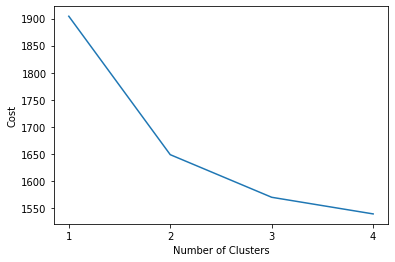

In [26]:
# Plot the results
plt.plot(cluster_range, costs)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.xticks(cluster_range)
plt.show()

In [27]:
# check if the elbow point is really what we observe from the Elbow plot above.
from kneed import KneeLocator

kl = KneeLocator(cluster_range, costs, curve="convex", direction="decreasing")
print("The optimal number of clusters is {}.".format(kl.elbow))

The optimal number of clusters is 2.


### Clustering Performance

In [28]:
kprototype = KPrototypes(n_clusters = 2, init='Huang', n_init = 5, verbose=1)
predicted = kprototype.fit_predict(X, categorical = categorical_pos)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 45448, ncost: 1656.8711683070294
Run: 1, iteration: 2/100, moves: 23799, ncost: 1651.268887585233
Run: 1, iteration: 3/100, moves: 466, ncost: 1651.2686789129
Run: 1, iteration: 4/100, moves: 2, ncost: 1651.2686789043664
Run: 1, iteration: 5/100, moves: 0, ncost: 1651.2686789043664
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 33028, ncost: 1652.1674883314065
Run: 2, iteration: 2/100, moves: 2015, ncost: 1652.1661159950102
Run: 2, iteration: 3/100, moves: 18, ncost: 1652.1661155805084
Run: 2, iteration: 4/100, moves: 0, ncost: 1652.1661155805084
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 16799, ncost: 1711.8463930737278
Run: 3, iteration: 2/100, moves: 14801, ncost: 1710.3910811035726
Run: 3, iteration: 3/100, moves: 189, ncost: 1710.390953

In [29]:
predicted

array([1, 0, 0, ..., 1, 0, 0], dtype=uint16)

In [30]:
# put the result back to original dataframe
hp = hp_copy.reset_index()
clustered = pd.DataFrame(predicted)
clustered.columns = ['predicted_cluster']
result = pd.concat([hp, clustered], axis = 1).reset_index()
result = result.drop(['index', 'level_0'], axis = 1)

# convert numerical columns to float type
for col in numerical_cols:
    result[col] = result[col].astype(str).str.replace(',','').astype(float)

result.head()

,Entity Type of the Provider,State Code of the Provider,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount,predicted_cluster
0,I,MO,Internal Medicine,Y,F,"Initial hospital inpatient care, typically 70 ...",N,27.0,24.0,27.0,200.587778,305.211111,157.262222,160.908889,1
1,I,NC,Obstetrics & Gynecology,Y,O,"Screening mammography, bilateral (2-view study...",N,175.0,175.0,175.0,123.730000,548.800000,118.830000,135.315257,0
2,I,CT,Podiatry,Y,O,"Established patient home visit, typically 25 m...",N,32.0,13.0,32.0,90.650000,155.000000,64.439688,60.595937,0
3,I,MO,Internal Medicine,Y,O,"Urinalysis, manual test",N,20.0,18.0,20.0,3.500000,5.000000,3.430000,3.430000,0
4,I,FL,Internal Medicine,Y,O,Injection beneath the skin or into muscle for ...,N,33.0,24.0,31.0,26.520000,40.000000,19.539394,19.057576,0


## Interpretation

### Categorical Data

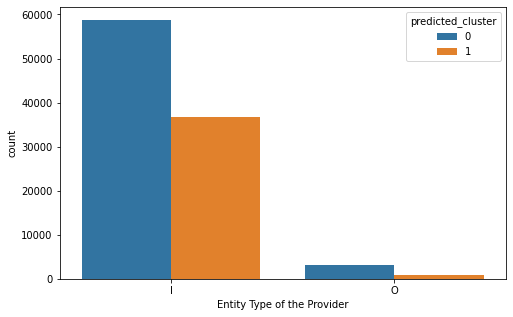

In [31]:
plt.subplots(figsize = (8,5))
sns.countplot(x=result['Entity Type of the Provider'],order=result['Entity Type of the Provider'].value_counts().index,hue=result['predicted_cluster'])
plt.show()

**Observation**
- "I" indicates a provider registered as individual, and "O" represents a provider registered as organization.
- Most of both clusters are registered as individuals. 

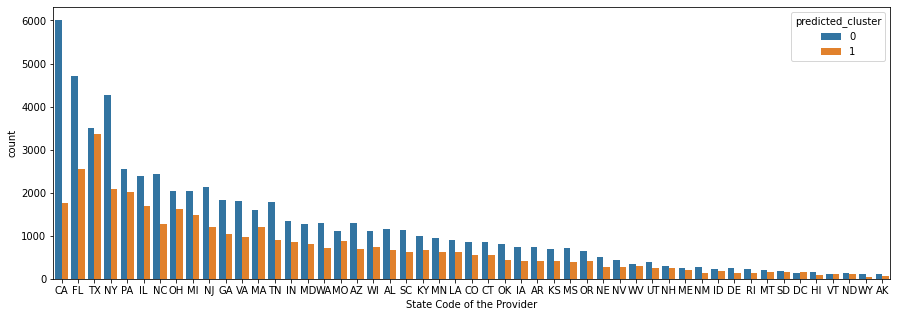

In [32]:
plt.subplots(figsize = (15,5))
sns.countplot(x=result['State Code of the Provider'],order=result['State Code of the Provider'].value_counts().index,hue=result['predicted_cluster'])
plt.show()

The numbers of the health care providers in cluster 0 are mostly larger than the ones in cluster 1, except DC and VT.  Overall, the states on the left (greater numbers) of the graph above, i.e. CA, FL, and TX, are ones of the top 10 states with the most medical fraud investigation and conviction (https://www.beckershospitalreview.com/legal-regulatory-issues/10-states-with-the-most-medicaid-fraud-investigations-convictions.html). However, it is possible that because there are more providers in these states, the numbers of fraud providers are also higher there. Accordingly, it's difficult to directly interpret this result. We need to further investigate individual states since they may have different rules, laws or circumstances that may affect clustering results.

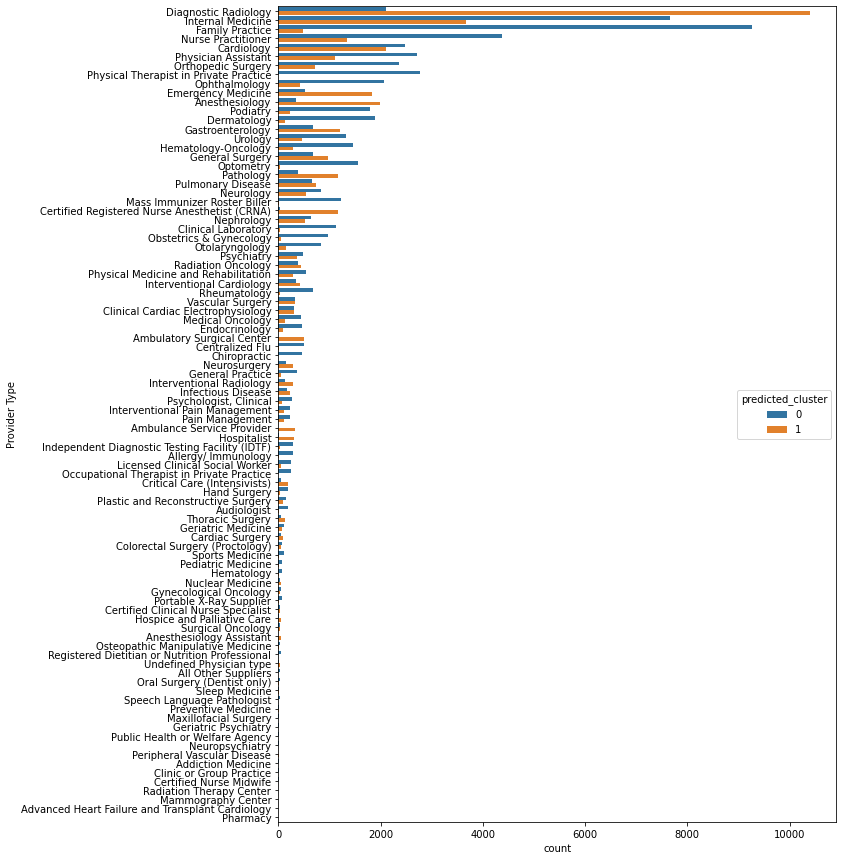

In [33]:
plt.subplots(figsize = (10,15))
sns.countplot(y=result['Provider Type'],order=result['Provider Type'].value_counts().index,hue=result['predicted_cluster'])
plt.show()

Provider type is from the provider specialty code specified on the claim.

Since there are much information provided for this feature, we will only focus on the provider types with count values are greater than 1000. The number of the provider types in cluster 0 are mostly greater than the ones in cluster 1. 

The provider types that are only included in cluster 0 are:
- phyical therapist in private practice
- mass immunizer roster biller
- centralized flu
- chiropractic.

The provider types whose their numbers of health providers in cluster 0 is less than cluster 1 are as follows:
- diagnostic radiology
- emergency medicine
- anesthesiology
- gastroenterology
- general surgery
- pathology
- pulmonary disease
- certified registered nurse anesthetist.

Moreover, the majority of provider types in cluster 0 are internal medicine, family practice and nurse practitioner. On the other hand, the main provider types in cluster 1 are diagnostic radiology, internal medicine and cardiology. 

Overall, the majority of healthcare provider types in cluster 0 are more possible to be fraudulent providers (https://www.statista.com/statistics/716048/provider-types-with-highest-number-of-convictions-for-medicaid-fraud/) than the ones in cluster 1, which includes higher degree of entry barriers, i.e. cardiology. 


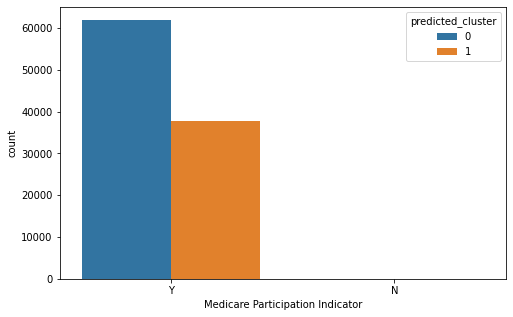

In [34]:
plt.subplots(figsize = (8,5))
sns.countplot(x=result['Medicare Participation Indicator'],order=result['Medicare Participation Indicator'].value_counts().index,hue=result['predicted_cluster'])
plt.show()

All providers participated in the Medicare. For future work, we can drop this column since there is no variation among the data.

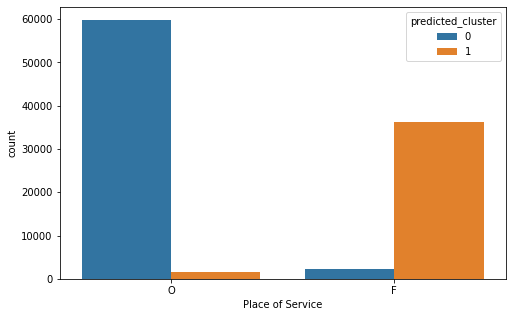

In [35]:
plt.subplots(figsize = (8,5))
sns.countplot(x=result['Place of Service'],order=result['Place of Service'].value_counts().index,hue=result['predicted_cluster'])
plt.show()

"O" indicates non-facility (or an office-setting) while "F" represents facility.

This feature provides a clear picture of how these two clusters are different. The providers in cluster 0 do not have facilities or might have different type of office setting, while the ones in cluster 1 have facilities.

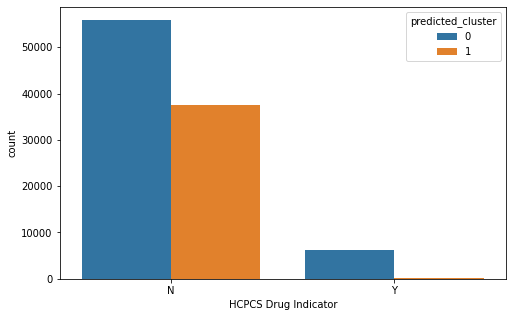

In [36]:
plt.subplots(figsize = (8,5))
sns.countplot(x=result['HCPCS Drug Indicator'],order=result['HCPCS Drug Indicator'].value_counts().index,hue=result['predicted_cluster'])
plt.show()

The HCPCS code identifies the specific medical service provided by the provider. The HCPCS drug indicator indicates whether the HCPCS code is listed on the Medicare Part B Drug Average Sales Prices (ASP). "Y" indicates Yes while "N" represents No.

The HCPCS codes of the providers in cluster 1 are not listed on ASP. However, majority of the ones in cluster 0 are also not in the ASP list. It's possible that most of the HCPCS codes furnished by the providers in this dataset haven't been listed on ASP.

### Numerical Data

In [111]:
# Since we will create similar plots for different columns, we will create the function to do so.
def create_plots(col_name, xlim_range):
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(121)
    ax1 = sns.boxplot(x='predicted_cluster', y=col_name, data=result)

    ax2 = fig.add_subplot(122)
    ax2 = sns.distplot(result[result['predicted_cluster']==0][col_name],label = 'cluster 0')
    ax2 = sns.distplot(result[result['predicted_cluster']==1][col_name],label = 'cluster 1')
    plt.xlim(xlim_range)
    plt.legend()
    plt.show()
    
    print("-"*20)
    print("Mean",col_name, "of cluster 0 is {}.".format(result[result['predicted_cluster']==0][col_name].mean().round(2)))
    print("Mean",col_name, "of cluster 1 is {}.".format(result[result['predicted_cluster']==1][col_name].mean().round(2)))
    print("-"*20)

/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


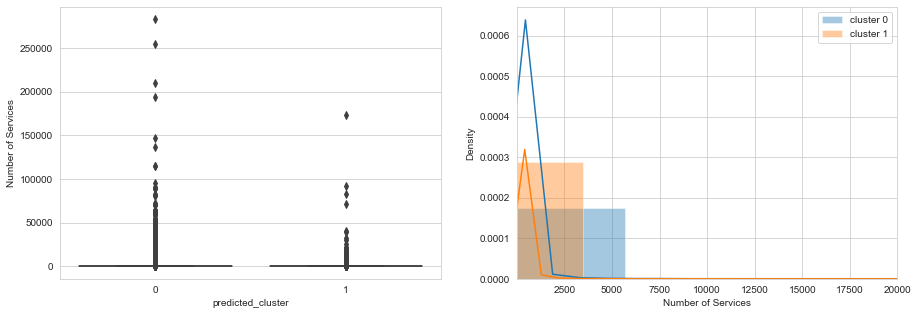

--------------------
Mean Number of Services of cluster 0 is 313.6.
Mean Number of Services of cluster 1 is 119.33.
--------------------


In [112]:
create_plots('Number of Services',[1,20000])

The cluster 0 has greater outliers than cluster 1. However, both clusters have very high number of services, i.e. above 5000. Since we do not have the information of time period, we do not know whether these numbers of services have been recorded since when, and whether these numbers are reasonable or not. 


/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


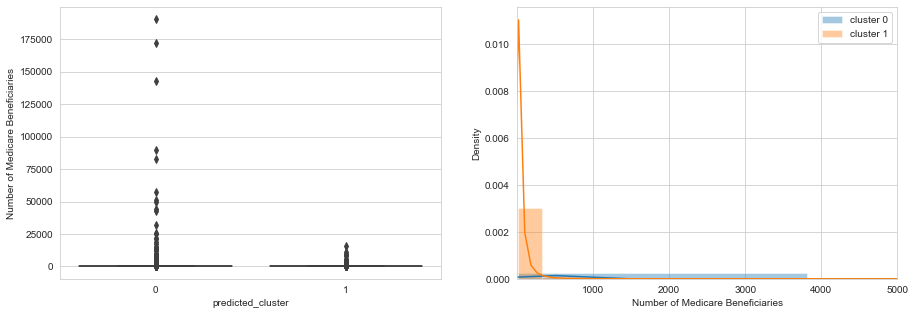

--------------------
Mean Number of Medicare Beneficiaries of cluster 0 is 102.95.
Mean Number of Medicare Beneficiaries of cluster 1 is 68.57.
--------------------


In [113]:
create_plots('Number of Medicare Beneficiaries',[1,5000])

The cluster 0 has greater outliers than cluster 1. This solution is similar to the result of number of services.

/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


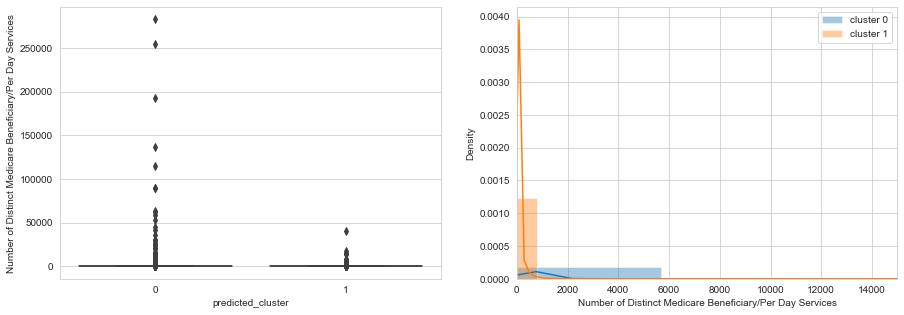

--------------------
Mean Number of Distinct Medicare Beneficiary/Per Day Services of cluster 0 is 172.41.
Mean Number of Distinct Medicare Beneficiary/Per Day Services of cluster 1 is 92.82.
--------------------


In [117]:
create_plots('Number of Distinct Medicare Beneficiary/Per Day Services',[0,15000])


The cluster 0 has greater outliers than cluster 1. This solution is similar to the results of the previous two features above. However, it seems to be unreasonable to have number of distinct medicare beneficianaries per day services greater than a thousand. Thus, it's possible that both clusters contain fruadulent providers, but cluster 0 includes more of the frauds than cluster 1.


/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


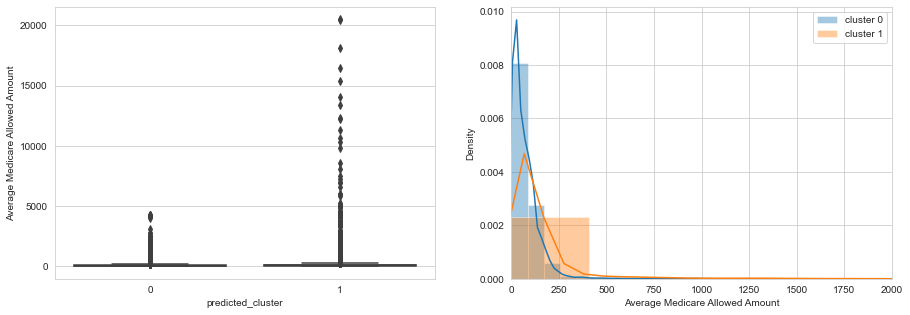

--------------------
Mean Average Medicare Allowed Amount of cluster 0 is 73.62.
Mean Average Medicare Allowed Amount of cluster 1 is 147.41.
--------------------


In [118]:
create_plots('Average Medicare Allowed Amount',[0,2000])


The cluster 0 has less outliers than cluster 1. However, the average medicare allowed amounts seem to be reasonable for both clusters.

/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


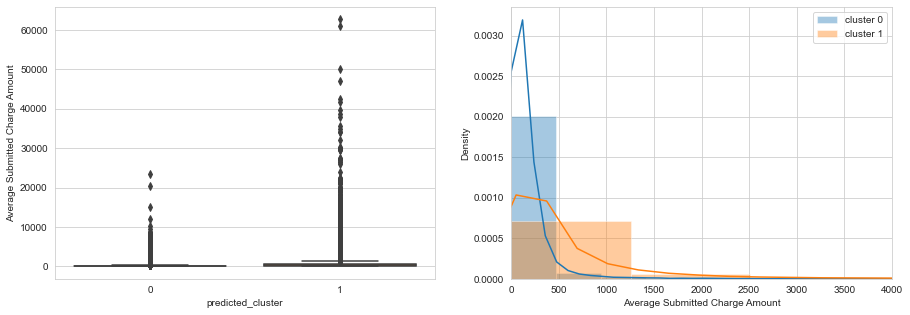

--------------------
Mean Average Submitted Charge Amount of cluster 0 is 178.77.
Mean Average Submitted Charge Amount of cluster 1 is 645.71.
--------------------


In [119]:
create_plots('Average Submitted Charge Amount', [0,4000])


The cluster 0 has less outliers than cluster 1. Most of the providers in cluster 1 seem to submitted the greater averge charges than the ones in cluster 0. However, previously we found that the providers in cluster 1 are specialized in more complicated fields. This is possible that the charges of treatment from the providers in this cluster will be higher than those in cluster 0.


/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


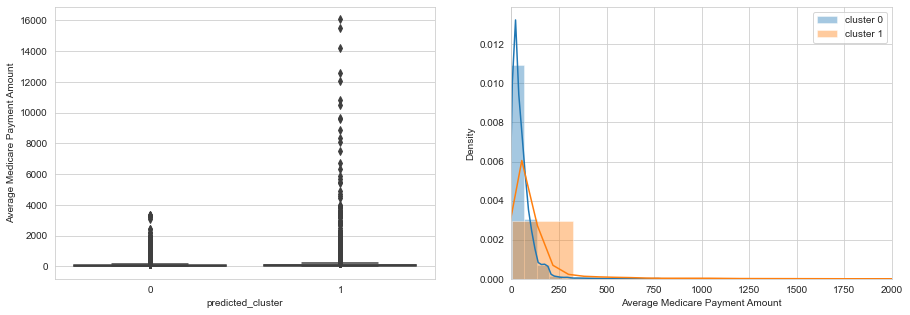

--------------------
Mean Average Medicare Payment Amount of cluster 0 is 55.54.
Mean Average Medicare Payment Amount of cluster 1 is 113.44.
--------------------


In [120]:
create_plots('Average Medicare Payment Amount', [0,2000])


It's similar to the result above of average submitted charge amount column, which seems to be reasonable. Since most of the providers in cluster 1 submitted greater amount of charges (based on the provider types, it's possibly due to complicated methods of treatment, i.e. surgery) than the ones in cluster 0, it seems to be reasonable that the average medicare payment of this cluster 1 will be greater than the ones in cluster 0. 


/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nammaneerath/anaconda3/envs/datasci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


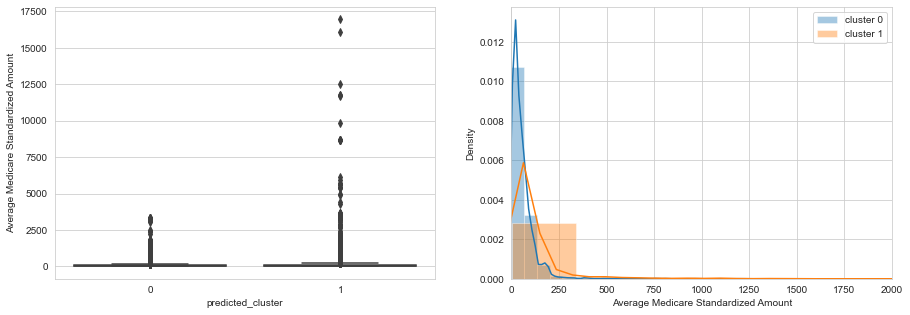

--------------------
Mean Average Medicare Standardized Amount of cluster 0 is 56.35.
Mean Average Medicare Standardized Amount of cluster 1 is 113.83.
--------------------


In [121]:
create_plots('Average Medicare Standardized Amount', [0,2000])


This result is also similar to the feature above. This is because this feature is correlated to the average medicare payment amount column.

## Summary

- **Cluster 0:**
    - Entity type of provider: individual (majority)
    - Provider type: internal medicine, family practice, nurse practitioner (3 majorities)
    - Place of services: non-facility
    - Number of services: 11 - 282,739; mean = 313.60
    - Number of medicare beneficiaries: 11 - 190,306; mean = 102.95
    - Number of distinct medicare beneficiary/per day services: 172.41 - 282,737; mean = 172.41
    - Average medicare allowed amount: 0.01 - 4280.33; mean = 73.62
    - Average submitted charge amount: 0.01 - 23526.46; mean = 178.77
    - Average medicare payment amount: 0.009 - 3324.58; mean = 55.54

- **Cluster 1:**
    - Entity type of provider: individual (majority)
    - Provider type: diagnostic radiology, internal medicine and cardiology (3 majorities)
    - Place of services: facility
    - Number of services: 11 - 173,026.10; mean = 119.33
    - Number of medicare beneficiaries: 11 - 16,072; mean = 68.57
    - Number of distinct medicare beneficiary/per day services: 11 - 40,051; mean = 92.82
    - Average medicare allowed amount: 0.11 - 20,494; mean = 147.41
    - Average submitted charge amount: 0.12 - 62,694; mean = 645.71
    - Average medicare payment amount: 0.08 - 16,067; mean = 113.44
 
In conclusion, cluster 0 seems to contain more fraudulent providers since the majority of provider types are common types of providers that are under investigation and conviction for fraud in healthcare. Also, most of the outliers of columns, i.e. number of services, number of medicare beneficiaries, and number of distinct medicare beneficiary/per day services, are very high and do not seem to be reasonable. However, it's also possible that there are a few/some fraudulent providers included in the cluster 1 since some providers in cluster 1 also have unreasonably high number of services, number of medicare beneficiaries, and number of distinct medicare beneficiary/per day services.

Although average medicare allowed amount, average submitted charge amount and average medicare payment amount of the providers in cluster 1 are greater than the ones in cluster 0, the values in these columns seem to be reasonable since the providers in this cluster 1 are mostly required higher degree of entry barriers or they are required expensive,sufficient equipments for treatment. Moreover, because the average medicare allowed amount of the providers in cluster 1 are mostly greater than the ones in cluster 0, the average submitted charge and average medicare payment amounts are also higher. 

Accordingly, most of the providers in cluster 0 are more likely fraudulent, while the ones in cluster 1 are mainly nonfraudulent. Thus, we need further study to better classify the data of individual groups.


## Future work


- Study individual states since they may have different rules, laws, or circumstances. We may get more detail and better identify fruadulent and nonfraudulent healthcare providers.
- Study individual clusters that we got in this study and get more information of each data structure since the clusters may not be perfect.
